<a href="https://colab.research.google.com/github/fahernkhan/Membuat-Model-Klasifikasi-Gambar/blob/main/Memprediksi_apakah_kamar_tersebut_rapi_atau_berantakan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Tahapan latihan kali ini adalah:

1.Memastikan TensorFlow yang digunakan di Google Colab adalah versi di atas 2.0.

2.Mengunduh dataset dan melakukan extract file dengan metode unzip.

3.Menampung direktori setiap kelas pada direktori train dan validasi ke dalam variabel.

4.Pre-processing data dengan image augmentation.

5.Mempersiapkan data latih yang akan dipelajari oleh model.

6.Membangun arsitektur model dengan Convolutional Neural Network (CNN).

7.Compile dan latih model dengan model.compile dan model.fit hingga mendapatkan akurasi yang diinginkan.

8.Menguji model yang telah dibuat dengan menggunakan gambar yang belum dikenali oleh model.

In [1]:
import tensorflow as tf
print(tf.__version__)

2.12.0


In [2]:
!wget --no-check-certificate \
  https://dicoding-academy-assets.sgp1.cdn.digitaloceanspaces.com/184/messy-vs-clean-room.zip \
  -O /tmp/messy_vs_clean_room.zip

--2023-04-19 05:15:38--  https://dicoding-academy-assets.sgp1.cdn.digitaloceanspaces.com/184/messy-vs-clean-room.zip
Resolving dicoding-academy-assets.sgp1.cdn.digitaloceanspaces.com (dicoding-academy-assets.sgp1.cdn.digitaloceanspaces.com)... 205.185.216.10, 205.185.216.42
Connecting to dicoding-academy-assets.sgp1.cdn.digitaloceanspaces.com (dicoding-academy-assets.sgp1.cdn.digitaloceanspaces.com)|205.185.216.10|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 70392746 (67M) [application/zip]
Saving to: ‘/tmp/messy_vs_clean_room.zip’

/tmp/messy_vs_clean 100%[===================>]  67.13M  8.47MB/s    in 12s     

2023-04-19 05:15:52 (5.61 MB/s) - ‘/tmp/messy_vs_clean_room.zip’ saved [70392746/70392746]



In [3]:
# melakukan ekstraksi pada file zip
import zipfile,os
local_zip = '/tmp/messy_vs_clean_room.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()
 
base_dir = '/tmp/images'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'val')

Melihat data

In [4]:
os.listdir('/tmp/images/train')

['messy', 'clean']

In [5]:
os.listdir('/tmp/images/val')

['messy', 'clean']

menerapkan ImageDataGenerator untuk data latih dan data validasi(preprocessing data, pelabelan sampel otomatis, dan augmentasi gambar.)

4.proses augmentasi gambar pada setiap sampel di dataset

In [8]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
 
train_datagen = ImageDataGenerator(
                    rescale=1./255,
                    rotation_range=20,
                    horizontal_flip=True,
                    shear_range = 0.2,
                    fill_mode = 'nearest')
 
test_datagen = ImageDataGenerator(
                    rescale=1./255)

siapkan data latih dan validasi dari kumpulan data gambar yang di-load dalam memori melalui fungsi flow()

In [13]:
train_generator = train_datagen.flow_from_directory(
        train_dir,  # direktori data latih
        target_size=(150, 150),  # mengubah resolusi seluruh gambar menjadi 150x150 piksel
        batch_size=4,
        # karena ini merupakan masalah klasifikasi 2 kelas, gunakan class_mode = 'binary'
        class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
        validation_dir, # direktori data validasi
        target_size=(150, 150), # mengubah resolusi seluruh gambar menjadi 150x150 piksel
        batch_size=4, 
        # karena ini merupakan masalah klasifikasi 2 kelas gunakan class_mode = 'binary'
        class_mode='binary')

Found 192 images belonging to 2 classes.
Found 20 images belonging to 2 classes.


Setelah data siap, kita bisa membangun model Convolutional Neural Network (CNN)

fungsi dari layer konvolusi adalah untuk mengekstraksi atribut pada gambar. Sedangkan layer max pooling berguna untuk mereduksi resolusi gambar sehingga proses pelatihan model lebih cepat

pada model CNN, proses klasifikasi gambar hanya berfokus pada atribut-atribut unik yang membedakan tiap kategori. Sehingga, teknik ini dinilai lebih optimal dibandingkan hanya menggunakan model MLP yang membedakan tiap kategori dengan melihat keseluruhan piksel-piksel pada gambar

In [14]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(150, 150, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(512, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

menggunakan fungsi summary() untuk melihat summary dari arsitektur model yang telah kita buat

In [15]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 74, 74, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 36, 36, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 34, 34, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 17, 17, 128)      0

melakukan compile model tersebut menggunakan fungsi compile()

In [16]:
# compile model dengan 'adam' optimizer loss function 'binary_crossentropy' 
model.compile(loss='binary_crossentropy',
              optimizer=tf.optimizers.Adam(),
              metrics=['accuracy'])

melabeli gambar dengan ImageDataGenerator dan melatih model dengan fungsi fit

In [17]:
# latih model dengan model.fit 
model.fit(
      train_generator,
      steps_per_epoch=25,  # berapa batch yang akan dieksekusi pada setiap epoch
      epochs=20, # tambahkan epochs jika akurasi model belum optimal
      validation_data=validation_generator, # menampilkan akurasi pengujian data validasi
      validation_steps=5,  # berapa batch yang akan dieksekusi pada setiap epoch
      verbose=2)

Epoch 1/20
25/25 - 21s - loss: 0.7988 - accuracy: 0.5000 - val_loss: 0.6921 - val_accuracy: 0.5000 - 21s/epoch - 838ms/step
Epoch 2/20
25/25 - 16s - loss: 0.6964 - accuracy: 0.5100 - val_loss: 0.6906 - val_accuracy: 0.5000 - 16s/epoch - 656ms/step
Epoch 3/20
25/25 - 16s - loss: 0.6956 - accuracy: 0.5700 - val_loss: 0.6919 - val_accuracy: 0.5000 - 16s/epoch - 641ms/step
Epoch 4/20
25/25 - 16s - loss: 0.6912 - accuracy: 0.5500 - val_loss: 0.6777 - val_accuracy: 0.6500 - 16s/epoch - 633ms/step
Epoch 5/20
25/25 - 16s - loss: 0.6697 - accuracy: 0.7200 - val_loss: 0.6122 - val_accuracy: 0.6000 - 16s/epoch - 640ms/step
Epoch 6/20
25/25 - 17s - loss: 0.6664 - accuracy: 0.6500 - val_loss: 0.7155 - val_accuracy: 0.5000 - 17s/epoch - 667ms/step
Epoch 7/20
25/25 - 15s - loss: 0.7200 - accuracy: 0.4200 - val_loss: 0.6933 - val_accuracy: 0.4500 - 15s/epoch - 612ms/step
Epoch 8/20
25/25 - 16s - loss: 0.6939 - accuracy: 0.4600 - val_loss: 0.6926 - val_accuracy: 0.6500 - 16s/epoch - 642ms/step
Epoch 9/

Saatnya menguji dengan gambar baru

Saving WhatsApp Image 2023-04-19 at 13.10.47.jpeg to WhatsApp Image 2023-04-19 at 13.10.47 (1).jpeg
1/1 [==============================] - 0s 93ms/step
WhatsApp Image 2023-04-19 at 13.10.47.jpeg
clean


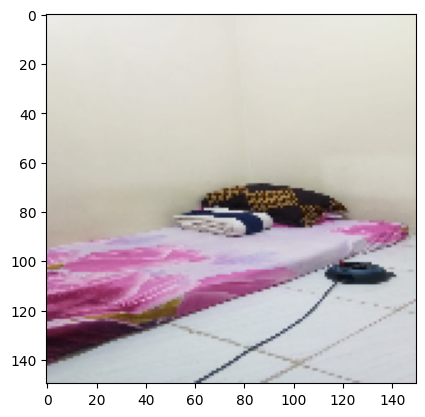

In [23]:
import numpy as np
from google.colab import files
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
 
uploaded = files.upload()
 
for fn in uploaded.keys():
 
  # predicting images
  path = fn
  img = image.load_img(path, target_size=(150,150))
 
  imgplot = plt.imshow(img)
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)
  images = np.vstack([x])
 
  classes = model.predict(images, batch_size=10)  
  print(fn)
  if classes==0:
   print('clean')
  else:
   print('messy')